In [1]:
#!{sys.executable} -m pip install --upgrade deepracer-utils


In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [3]:
from deepracer.tracks import TrackIO, Track, GeometryUtils, TrackPlotter
from deepracer.tracks.track_utils import track_breakdown, track_meta
import math
import numpy as np


In [4]:
tu = TrackIO()
track_name = "2022_reinvent_champ"
track: Track = tu.load_track(track_name)


Loaded 112 waypoints


<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


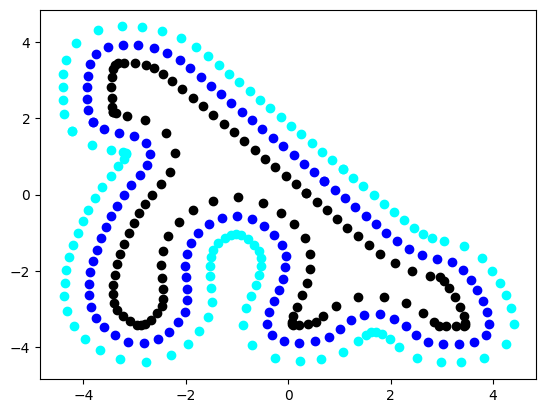

In [5]:
TrackPlotter.plot_track(track)


In [6]:
assert len(track.outer_border) == len(track.inner_border)
track.outer_border
track.inner_border

track_widths = []
for i, _ in enumerate(track.outer_border):
    track_widths.append(
        math.dist(track.outer_border[i], track.inner_border[i]))

track_widths[:5]


[0.950000314998835,
 0.9500000823415634,
 0.9500002285517173,
 0.949999807097509,
 0.9499996967100073]

In [7]:
track.center_line[0], track.center_line[-1]

(array([0.7088999 , 0.35731884]), array([0.7088999 , 0.35731884]))

In [8]:
len(track_widths)

112

In [9]:
max(track_widths), min(track_widths), sum(track_widths) / len(track_widths)


(0.9500009974512499, 0.9499992170703725, 0.9499999806774512)

In [10]:
def put_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint) -> tuple:
    """Move all the vectors to the origin relative to the closest_waypoint"""
    new_closest_wp = (0, 0)
    
    new_second_closest_wp = (
        round(the_second_closest_wp[0] - closest_waypoint[0], 2), round(the_second_closest_wp[1] - closest_waypoint[1], 2))
    new_furthest_wp = (
        round(furthest_waypoint[0] - closest_waypoint[0], 2), round(furthest_waypoint[1] - closest_waypoint[1],2))
    # new_second_closest_wp = (
    #     the_second_closest_wp[0] - closest_waypoint[0], the_second_closest_wp[1] - closest_waypoint[1])
    # new_furthest_wp = (
    #     furthest_waypoint[0] - closest_waypoint[0], furthest_waypoint[1] - closest_waypoint[1])
    return (new_closest_wp,  new_second_closest_wp, new_furthest_wp)
    
tests = [
    {
        'data': ((-4, 8), (-4, 4), (-8, 4)),
        'expected_point': ((0, 0), (0, -4), (-4, -4))
    },
    {
        'data': ((6.84, 0.88), (6.99, 1.01), (7.11, 1.17)),
        'expected_point': ((0, 0), (0.15, 0.13), (0.27, 0.29))
    },
]

for test in tests:
    result = put_to_origin(*test['data'])
    
    for i, point in enumerate(result):
        expected_point = test['expected_point'][i]
        calculated_point = result[i]
        assert expected_point[0] == calculated_point[0] and expected_point[1] == calculated_point[1], f'Result {calculated_point} did not match expected value {expected_point}'
        print(f'For test {test["data"]}, expected value {expected_point} and got {calculated_point}')

For test ((-4, 8), (-4, 4), (-8, 4)), expected value (0, 0) and got (0, 0)
For test ((-4, 8), (-4, 4), (-8, 4)), expected value (0, -4) and got (0, -4)
For test ((-4, 8), (-4, 4), (-8, 4)), expected value (-4, -4) and got (-4, -4)
For test ((6.84, 0.88), (6.99, 1.01), (7.11, 1.17)), expected value (0, 0) and got (0, 0)
For test ((6.84, 0.88), (6.99, 1.01), (7.11, 1.17)), expected value (0.15, 0.13) and got (0.15, 0.13)
For test ((6.84, 0.88), (6.99, 1.01), (7.11, 1.17)), expected value (0.27, 0.29) and got (0.27, 0.29)


In [11]:
def angle_of_vectors(ab,cd):
    """Returns the angle of the vectors"""
    dot_product = ab[0]*cd[0] + ab[1]*cd[1]
    mod_of_vector_1 = math.sqrt( ab[0]** 2 + ab[1]** 2)*math.sqrt(cd[0] ** 2 + cd[1] ** 2) 
    angle = dot_product/mod_of_vector_1
    angle_in_degree = math.degrees(math.acos(angle))
    return round(angle_in_degree,2)
 
tests = [
    {
        'data': ((8,6), (7,9)),
        'expected_angle': 15.26
    },
    {
        'data': ((8,6), (7,9)),
        'expected_angle': 15.26
    },
    {
        'data': ((0.15, 0.13), (0.27, 0.29)),
        'expected_angle': 6.13
    },
]

for test in tests:
    result = angle_of_vectors(test['data'][0], test['data'][1])
    expected_angle = test['expected_angle']
    calculated_angle = result
    assert expected_angle == calculated_angle, f'Result {calculated_angle} did not match expected value {expected_angle}'
    print(f'For test {test["data"]}, expected value {expected_angle} and got {calculated_angle}')

For test ((8, 6), (7, 9)), expected value 15.26 and got 15.26
For test ((8, 6), (7, 9)), expected value 15.26 and got 15.26
For test ((0.15, 0.13), (0.27, 0.29)), expected value 6.13 and got 6.13


In [12]:
def rotate_around_origin(origin, point, angle, decimel_points=2) -> tuple: # <<<<< SOMETHING IS WRONG HERE
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    # print('origin', origin, 'point', point, 'angle', angle, 'decimel_points', decimel_points)
    angle = math.radians(angle)
    ox, oy = origin
    # print('ox, oy', ox, oy)
    px, py = point
    # print('px, py', px, py)

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    
    return round(qx, decimel_points), round(qy, decimel_points)

tests = [
    {
        'data': ((0, 0), (-4, -4), 180),
        'expected_point': (4, 4)
    },
#     {
#         'data': ((0, 0), (0.15, 0.13), 6.13),
#         'expected_point': (0.163, 0.113) ## Confirmed twice
#     },
]


for test in tests:
    result = rotate_around_origin(*test['data'])
    
    for i, point in enumerate(result):
        expected_point = test['expected_point']
        calculated_point = result
        print('Result was,', result)
        assert expected_point[0] == calculated_point[0] and expected_point[1] == calculated_point[1], f'Result {calculated_point} did not match expected value {expected_point}'
        print(bcolors.OKGREEN + "Test Passes" + bcolors.ENDC)
        print(f'For test {test["data"]}, expected value {expected_point} and got {calculated_point}')


Result was, (4.0, 4.0)
Test Passes
For test ((0, 0), (-4, -4), 180), expected value (4, 4) and got (4.0, 4.0)
Result was, (4.0, 4.0)
Test Passes
For test ((0, 0), (-4, -4), 180), expected value (4, 4) and got (4.0, 4.0)


In [13]:
def transform_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint) -> tuple:
    """Align the vectors so that the closest and second closest waypoint are 0 on the x axis. This depends on the closest waypoint having the coordinates origin at 0,0"""
    assert(closest_waypoint[0] == 0 and closest_waypoint[1] == 0 ,   'closest_waypoint[0] == 0 and closest_waypoint[1]', closest_waypoint[0] , closest_waypoint[1] )
    second_point_origin_dist = math.dist((0,0), the_second_closest_wp)
    second_point_transformed = (0, second_point_origin_dist)
    degrees_of_rotation_needed = angle_of_vectors(second_point_transformed, the_second_closest_wp)
    
    new_second_closest_wp = rotate_around_origin(closest_waypoint, the_second_closest_wp, degrees_of_rotation_needed)

    new_furthest_wp = rotate_around_origin(closest_waypoint, furthest_waypoint, degrees_of_rotation_needed)

    return ( closest_waypoint, new_second_closest_wp, new_furthest_wp )

tests = [
    {
        'data': ((0, 0), (0, -4), (-4, -4)),
        'expected_point': ((0, 0), (0, 4), (4, 4))
    },
]

for test in tests:
    result = transform_to_origin(*test['data'])
    print('Result', result,'Test', test)
    
    for i, point in enumerate(result):
        expected_point = test['expected_point'][i]
        calculated_point = result[i]
        assert expected_point[0] == calculated_point[0] and expected_point[1] == calculated_point[1], f'Result {calculated_point} did not match expected value {expected_point}'
        print(f'For test {test["data"]}, expected value {expected_point} and got {calculated_point}')

Result ((0, 0), (0.0, 4.0), (4.0, 4.0)) Test {'data': ((0, 0), (0, -4), (-4, -4)), 'expected_point': ((0, 0), (0, 4), (4, 4))}
For test ((0, 0), (0, -4), (-4, -4)), expected value (0, 0) and got (0, 0)
For test ((0, 0), (0, -4), (-4, -4)), expected value (0, 4) and got (0.0, 4.0)
For test ((0, 0), (0, -4), (-4, -4)), expected value (4, 4) and got (4.0, 4.0)


<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_721378/68622081.py:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(closest_waypoint[0] == 0 and closest_waypoint[1] == 0 ,   'closest_waypoint[0] == 0 and closest_waypoint[1]', closest_waypoint[0] , closest_waypoint[1] )


In [14]:


def get_angle_deg(closest_waypoint, the_second_closest_wp, furthest_waypoint):
    """Get angle in degrees"""
    
    closest_waypoint, the_second_closest_wp, furthest_waypoint = put_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint)
    
    # print('after moving to origin', c1losest_waypoint, the_second_closest_wp, furthest_waypoint)
    
    closest_waypoint, the_second_closest_wp, furthest_waypoint = transform_to_origin(closest_waypoint, the_second_closest_wp, furthest_waypoint)
    
    # print('transform_to_origin', closest_waypoint, the_second_closest_wp, furthest_waypoint)

    angle = math.degrees(math.atan2(
        furthest_waypoint[0], furthest_waypoint[1]))
    
    return angle


tests = [
    {
        'data': ((0, 0), (0, 5), (-5, 5)),
        'expected_ang': -45
    },
    {
        'data': ((0, 0), (0, 5), (-4, 0)),
        'expected_ang': -90
    },
    {
        'data': ((0, 0), (0, 5), (-5, 0)),
        'expected_ang': -90
    },
    {
        'data': ((0, 0), (0, 5), (-5, 0)),
        'expected_ang': -90
    },
    # {
    #     'data': ((6.84, 0.88), (6.99, 1.01), (7.11, 1.17)),
    #     'expected_ang': -6.1
    # },
]

for test in tests:
    result = get_angle_deg(*test['data'])
    expected_angle = test['expected_ang']
    print(f'For test {test}, expected value {expected_angle} and got {result}')
    assert expected_angle == result, f'Result {result} did not match expected value {expected_angle}'


For test {'data': ((0, 0), (0, 5), (-5, 5)), 'expected_ang': -45}, expected value -45 and got -45.0
For test {'data': ((0, 0), (0, 5), (-4, 0)), 'expected_ang': -90}, expected value -90 and got -90.0
For test {'data': ((0, 0), (0, 5), (-5, 0)), 'expected_ang': -90}, expected value -90 and got -90.0
For test {'data': ((0, 0), (0, 5), (-5, 0)), 'expected_ang': -90}, expected value -90 and got -90.0


In [15]:
angles = []

for i, _ in enumerate(track.center_line):
    is_last_index = i == len(track.center_line) - 1
    is_second_last_index = i == len(track.center_line) - 2
    
    if is_last_index == True:
        print('Is last index', i)
        print('Break on last index because it is a repeat of the first waypoint')
        break
    
    if is_second_last_index == True:
        print('is_second_last_index', i)
        
        
    # print('is_last_index',is_last_index,'is_second_last_index',is_second_last_index)
    last_index = i+1

    second_point = track.center_line[0] if is_last_index else track.center_line[last_index]

    third_point = track.center_line[0] if is_second_last_index else \
        track.center_line[1] \
        if is_last_index \
        else track.center_line[i+2]

    current_wp = track.center_line[i]
    
    angle_result = get_angle_deg(
        current_wp, second_point, third_point)
    
    if math.isnan(angle_result):
        print('Angle result', angle_result)
        print('NaN was found')
        print(  
            'is_last_index', is_last_index,
            'is_second_last_index', is_second_last_index,
            'current_wp', current_wp,
            'last_index', last_index,
            'second_point', second_point,
            'third_point', third_point,
        )


    angles.append(angle_result)
    

# print('Angles \n', angles)
print(
    f'The individual angles stats are, right_max: {max(angles)}, left_max: {min(angles)}, mean: {sum(angles) / len(angles)}, amount: {len(angles)}')


Angle result nan
NaN was found
is_last_index False is_second_last_index False current_wp [-3.81859243  1.91309297] last_index 27 second_point [-3.81859243  1.91309297] third_point [-3.59050393  1.71841502]
is_second_last_index 110
Is last index 111
Break on last index because it is a repeat of the first waypoint
The individual angles stats are, right_max: 146.30993247402023, left_max: -179.0451587461278, mean: nan, amount: 111


/tmp/ipykernel_721378/1434163933.py:5: RuntimeWarning: invalid value encountered in double_scalars
  angle = dot_product/mod_of_vector_1


In [16]:
import pandas as pd

df = pd.DataFrame({ 'angles': angles })
df.iloc[26]
# df.to_csv('./angles.csv')




angles   NaN
Name: 26, dtype: float64

Angle for wp 0 [0.7088999  0.35731884] -82.40535663140857 [0.7088999  0.35731884]
Angle for wp 1 [0.50769304 0.58412436] -82.40535663140857 [0.50769304 0.58412436]
Angle for wp 2 [0.30638189 0.81083442] -83.3455749539934 [0.30638189 0.81083442]
Angle for wp 3 [0.10454195 1.03707612] -84.38241940987318 [0.10454195 1.03707612]
Angle for wp 4 [-0.09996715  1.26089245] -82.40535663140857 [-0.09996715  1.26089245]
Angle for wp 5 [-0.30175268  1.48718005] -82.40535663140857 [-0.30175268  1.48718005]
Angle for wp 6 [-0.50307736  1.71387905] -82.40535663140857 [-0.50307736  1.71387905]
Angle for wp 7 [-0.70425647  1.94070756] -82.40535663140857 [-0.70425647  1.94070756]
Angle for wp 8 [-0.9053517   2.16760993] -82.40535663140857 [-0.9053517   2.16760993]
Angle for wp 9 [-1.10635018  2.39459753] -82.40535663140857 [-1.10635018  2.39459753]
Angle for wp 10 [-1.30724964  2.62167251] -82.40535663140857 [-1.30724964  2.62167251]
Angle for wp 11 [-1.50806803  2.84881997] -82.40535663140857 [-1.50806

ValueError: cannot convert float NaN to integer

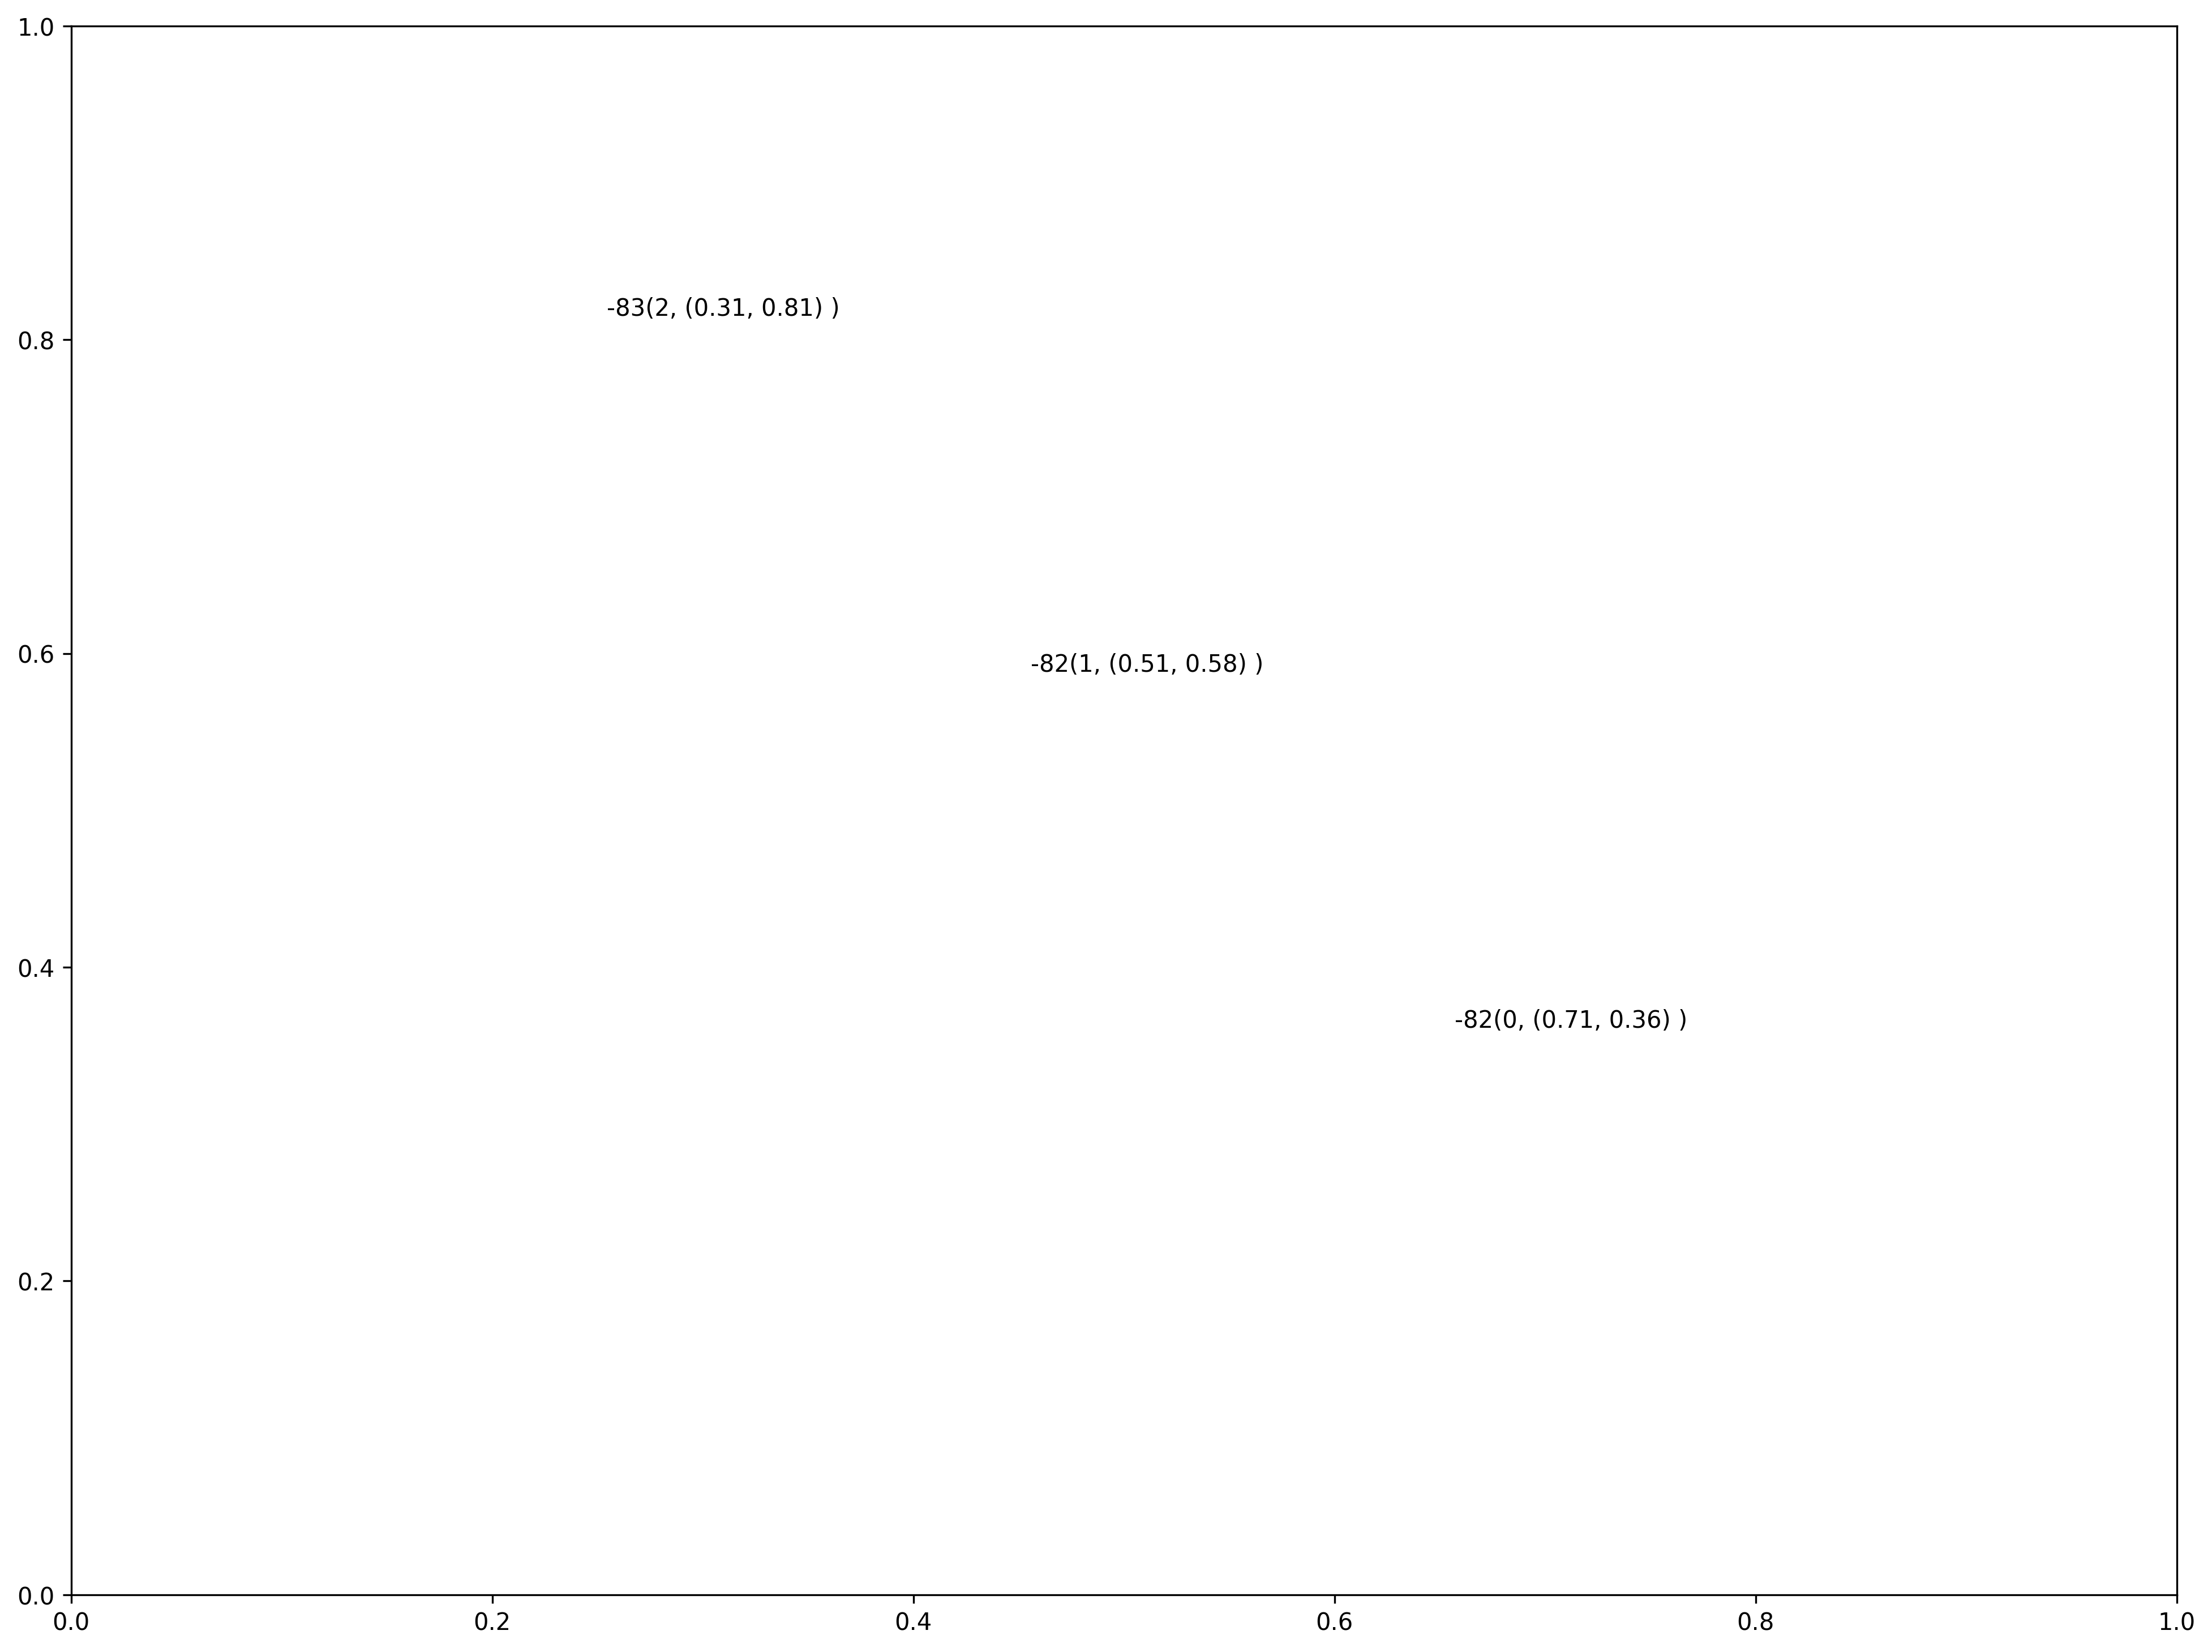

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12), dpi=300)

def plot_coords(ax, track, angles, annotate=False, ):                                                        
    if annotate is True:                                                         
        for i, wp in enumerate(track.center_line):
            is_last_index = i == len(track.center_line) - 1

            if is_last_index == True:
                print('Is last index', i)
                print('Break on last index because it is a repeat of the first waypoint')
                return
            relative_angle = angles[i]
            
            print(f'Angle for wp {i}',wp, relative_angle, wp)
            plt.annotate(
                    str(round(angles[i])) + f'({str(i)}, { (round(wp[0],2), round(wp[1],2))} )', # this is the text
                    (wp), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(3,3), # distance from text to points (x,y)
                    ha='center'
                ) # horizontal alignment can be left, right or center  
              
plot_coords(1, track, angles, True )

for point in track.center_line:
    plt.scatter(point[0], point[1], c="blue")
plt.show()



In [ ]:
# !pip install plotly

: 

In [24]:
track.center_line

array([[ 0.7088999 ,  0.35731884],
       [ 0.50769304,  0.58412436],
       [ 0.30638189,  0.81083442],
       [ 0.10454195,  1.03707612],
       [-0.09996715,  1.26089245],
       [-0.30175268,  1.48718005],
       [-0.50307736,  1.71387905],
       [-0.70425647,  1.94070756],
       [-0.9053517 ,  2.16760993],
       [-1.10635018,  2.39459753],
       [-1.30724964,  2.62167251],
       [-1.50806803,  2.84881997],
       [-1.70906854,  3.07580602],
       [-1.91061896,  3.30230403],
       [-2.12099993,  3.52052748],
       [-2.35695493,  3.7103616 ],
       [-2.62819242,  3.84422195],
       [-2.92411852,  3.90804255],
       [-3.22665656,  3.92702341],
       [-3.52449596,  3.87578845],
       [-3.75881696,  3.68951452],
       [-3.87371588,  3.41031849],
       [-3.91732717,  3.11042392],
       [-3.92767596,  2.807428  ],
       [-3.92080259,  2.50431049],
       [-3.90397203,  2.20158052],
       [-3.81859243,  1.91309297],
       [-3.81859243,  1.91309297],
       [-3.59050393,

In [18]:
center_track_angles = list(map(lambda w: { 'x': w[0][0], 'y': w[0][1], 'angle': w[1]} ,zip(track.center_line, angles)))
center_track_angles

[{'x': 0.7088999003171921,
  'y': 0.3573188427835703,
  'angle': -82.40535663140857},
 {'x': 0.5076930373907089,
  'y': 0.584124356508255,
  'angle': -82.40535663140857},
 {'x': 0.3063818905502558,
  'y': 0.8108344227075577,
  'angle': -83.3455749539934},
 {'x': 0.10454194992780445,
  'y': 1.037076115608218,
  'angle': -84.38241940987318},
 {'x': -0.09996715188026428,
  'y': 1.2608924508094788,
  'angle': -82.40535663140857},
 {'x': -0.30175267718732357,
  'y': 1.4871800541877747,
  'angle': -82.40535663140857},
 {'x': -0.503077358007431,
  'y': 1.7138790488243103,
  'angle': -82.40535663140857},
 {'x': -0.7042564749717712,
  'y': 1.9407075643539429,
  'angle': -82.40535663140857},
 {'x': -0.9053516983985901,
  'y': 2.167609930038452,
  'angle': -82.40535663140857},
 {'x': -1.1063501834869385,
  'y': 2.3945975303649902,
  'angle': -82.40535663140857},
 {'x': -1.3072496354579926,
  'y': 2.621672511100769,
  'angle': -82.40535663140857},
 {'x': -1.5080680251121545,
  'y': 2.8488199710845

In [19]:
import plotly.express as px


df = pd.DataFrame.from_records(center_track_angles)
print(df)


            x         y      angle
0    0.708900  0.357319 -82.405357
1    0.507693  0.584124 -82.405357
2    0.306382  0.810834 -83.345575
3    0.104542  1.037076 -84.382419
4   -0.099967  1.260892 -82.405357
..        ...       ...        ...
106  1.711526 -0.779677 -82.405357
107  1.510398 -0.552799 -82.405357
108  1.310993 -0.324428 -82.405357
109  1.110917 -0.096638 -82.405357
110  0.910141  0.130542 -82.405357

[111 rows x 3 columns]


In [32]:
inner_limits_df = pd.DataFrame.from_records(list(map(lambda w: { 'x': w[0], 'y': w[1]},track.inner_border)))
outer_border_df = pd.DataFrame.from_records(list(map(lambda w: { 'x': w[0], 'y': w[1]},track.outer_border)))
outer_border_df

,x,y
0,1.064206,0.672569
1,0.862948,0.899432
2,0.661196,1.126638
3,0.457101,1.355395
4,0.252629,1.579170
...,...,...
107,1.867020,-0.239039
108,1.668334,-0.011487
109,1.467320,0.217371
110,1.265743,0.445458


In [41]:
import plotly.graph_objects as go

rounded = df.copy()
rounded['angle'] = df['angle'].round()
fig1 = px.scatter(rounded, x="x", y="y", color="angle", text="angle",width=1000, height=1000)
fig2 = px.scatter(inner_limits_df, x="x", y="y", width=1000, height=1000)
fig3 = px.scatter(outer_border_df, x="x", y="y", width=1000, height=1000)
all_fig = go.Figure(data=fig1.data + fig2.data + fig3.data)

all_fig.show()

In [39]:
rounded = df.copy()
rounded['angle'] = df['angle'].round()
rounded['x_str'] = df['x'].round().astype(str)
rounded['y_str'] = df['y'].round().astype(str)
rounded['waypoint'] = [str(x) + ' , ' + y for x, y in zip(rounded['x_str'], rounded['y_str'])]
rounded['waypoint'] = df.index.astype(str)
fig1 = px.scatter(rounded, x="x", y="y", color="angle", text="waypoint",width=1000, height=1000)
fig2 = px.scatter(inner_limits_df, x="x", y="y", width=1000, height=1000)
fig3 = px.scatter(outer_border_df, x="x", y="y", width=1000, height=1000)
all_fig = go.Figure(data=fig1.data + fig2.data + fig3.data)





In [22]:
# CORNER_THRESHOLD_ANGLE = 0.5

# corners = []
# current_corner = {'id': 0}

# for i, _ in enumerate(track.center_line):

#     is_last_index = i == len(track.center_line) -1

#     second_point = track.center_line[0] if is_last_index else track.center_line[i+1]

#     angles.append(get_angle_deg(track.center_line[i], second_point))

# print(
#     f'The individual angles stats are, max: {max(angles)}, min: {min(angles)}, mean: {sum(angles) / len(angles)}')
